In [38]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

def add_hull(master_df, rEtaKsstats_dict, GROUP='group', debug=False):

    master_df_copy = master_df.copy()
    master_df_copy = master_df.set_index(GROUP)
    groups = master_df_copy.index
    master_df_copy["hull"] = ""

    for group in groups:
        if master_df_copy.loc[group, "total_samples"] < 10:
            master_df_copy.loc[group, "hull"] = np.nan
           
        else:
            drop_keys =list(rEtaKsstats_dict[group].keys())[-3:]
            if debug:
                print(drop_keys)
            pre_optimization = pd.DataFrame(rEtaKsstats_dict[group]).drop(drop_keys, axis = 1 )
            optimization = pd.DataFrame(rEtaKsstats_dict[group])[drop_keys]
            optimization = optimization.rename(columns = {"r_optimize": "r", "eta_optimize": "eta", drop_keys[-1]: "ksstat"})
            optimization = optimization.dropna()
            full_df = pre_optimization.merge(optimization, on=["r", "eta"], how="outer")
            full_df = full_df.set_index(["r", "eta"])
            full_df["ksstat"] = full_df.min(axis=1)
            full_df = full_df.reset_index()
            full_df = full_df[["r", "eta", "ksstat"]]
            full_df["1/beta"] = full_df["r"]/(full_df["eta"] + 1.5)
            MULT = 1.2
            cutoff = max(min(full_df["ksstat"]) * MULT, master_df_copy.loc[group, "kstest_stat_cutoff_0.05"], 0.01)
            filtered_df = full_df[full_df["ksstat"] < cutoff]
            points = np.column_stack((filtered_df["r"], filtered_df["1/beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            hull = ConvexHull(points)
            master_df_copy.loc[group, "hull"] = hull

    return master_df_copy.reset_index()

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta', # 'initial_scale',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', # 'best_scale', 
       'kstest_stat_best', # 'n_pval_0.05',
        'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
       'dataset', 'subset', 'transform', 'orientation', 'channel', 'github_plot', 'dataset_type', 'hull']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

for path in all_paths:
    if 'scaleTesting' in path or 'standardTesting' in path:
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    elif parts[0] == 'results':
        parts = parts[2:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    elif "learned" in path:
        dataset, subset, transform, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df = master_df.rename(columns={'filter_group' : 'channel'})
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]

    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything']:
        master_df['dataset_type'] = 'natural'


    GROUP = 'layer' if transform.split("-")[0] == 'wavelet' else ('band' if transform.split("-")[0] == 'fourier' else 'filter_idx')
    rEtaKsstatsDict = pd.read_pickle(path[:-18] + "cache" + os.sep + "rEtaKsstats_dict.pickle")
    # total_samples = pd.read_pickle(path[:-18] + "cache" + os.sep + "rEtaKsstats_dict.pickle")
    
    master_df = add_hull(master_df, rEtaKsstatsDict)
    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['best_1/beta'] = 1/main_df['best_beta']
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)


frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
# main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).reset_index() #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
print(main_df.shape)
main_df.head()

(768, 36)


,dataset,subset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,...,kstest_pval_t,kstest_pval_gengamma,orientation,channel,github_plot,dataset_type,hull,best_beta,best_1/beta,beat_all_priors
0,agriVision,full,fourier,2,1292.94670,749.107670,2108.43070,421.84155,123.97443,696.23804,...,1.382990e-14,0.018082,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,38.000000,0.026316,1
1,agriVision,full,fourier,5,662.65440,382.089750,1248.61780,628.03000,108.21224,1663.23950,...,3.910420e-23,0.007144,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,43.333333,0.023077,1
2,agriVision,full,fourier,8,256.63390,133.792040,650.84560,1363.73070,99.36560,3639.23580,...,2.031100e-27,0.000112,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,53.333333,0.018750,1
3,agriVision,full,fourier,11,121.96157,57.215298,390.19293,2698.31760,93.68093,4889.27800,...,1.306640e-42,0.000013,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,55.555556,0.018000,1
4,agriVision,full,fourier,14,48.46801,23.179575,151.67955,2654.29520,86.30504,4711.62940,...,1.510880e-83,0.000004,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,56.666667,0.017647,1


In [39]:
# os.path.join(ROOT_DIR, 'transformed-data', f"{'-'.join([dataset, subset, transform, channel])}-size.pickle")

In [40]:
main_df = main_df.merge(pd.read_csv('result_categorization - combined_categories.csv')[['github_plot', 'failure_category', 'failure_type', 'which_ones']], on='github_plot', how='left')
main_df['dataset'].value_counts()

dataset
coco               192
pastis             135
agriVision         116
segmentAnything    108
spaceNet            96
syntheticMRI2D      72
syntheticMRI3D      49
Name: count, dtype: int64

In [41]:
main_df[['total_samples', 'dataset', 'subset', 'transform', 'orientation', 'channel', 'group', 'kstest_stat_best', 'kstest_stat_cutoff_0.05', 'beat_all_priors', 'failure_category', 'failure_type', 'which_ones', 'github_plot']].to_csv('combined_categories.csv')

# KS Stat (r, eta) & (r, 1/beta) Point Plots

In [42]:
fontsize = 15
markersize = 10
labelsize = 15
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
]

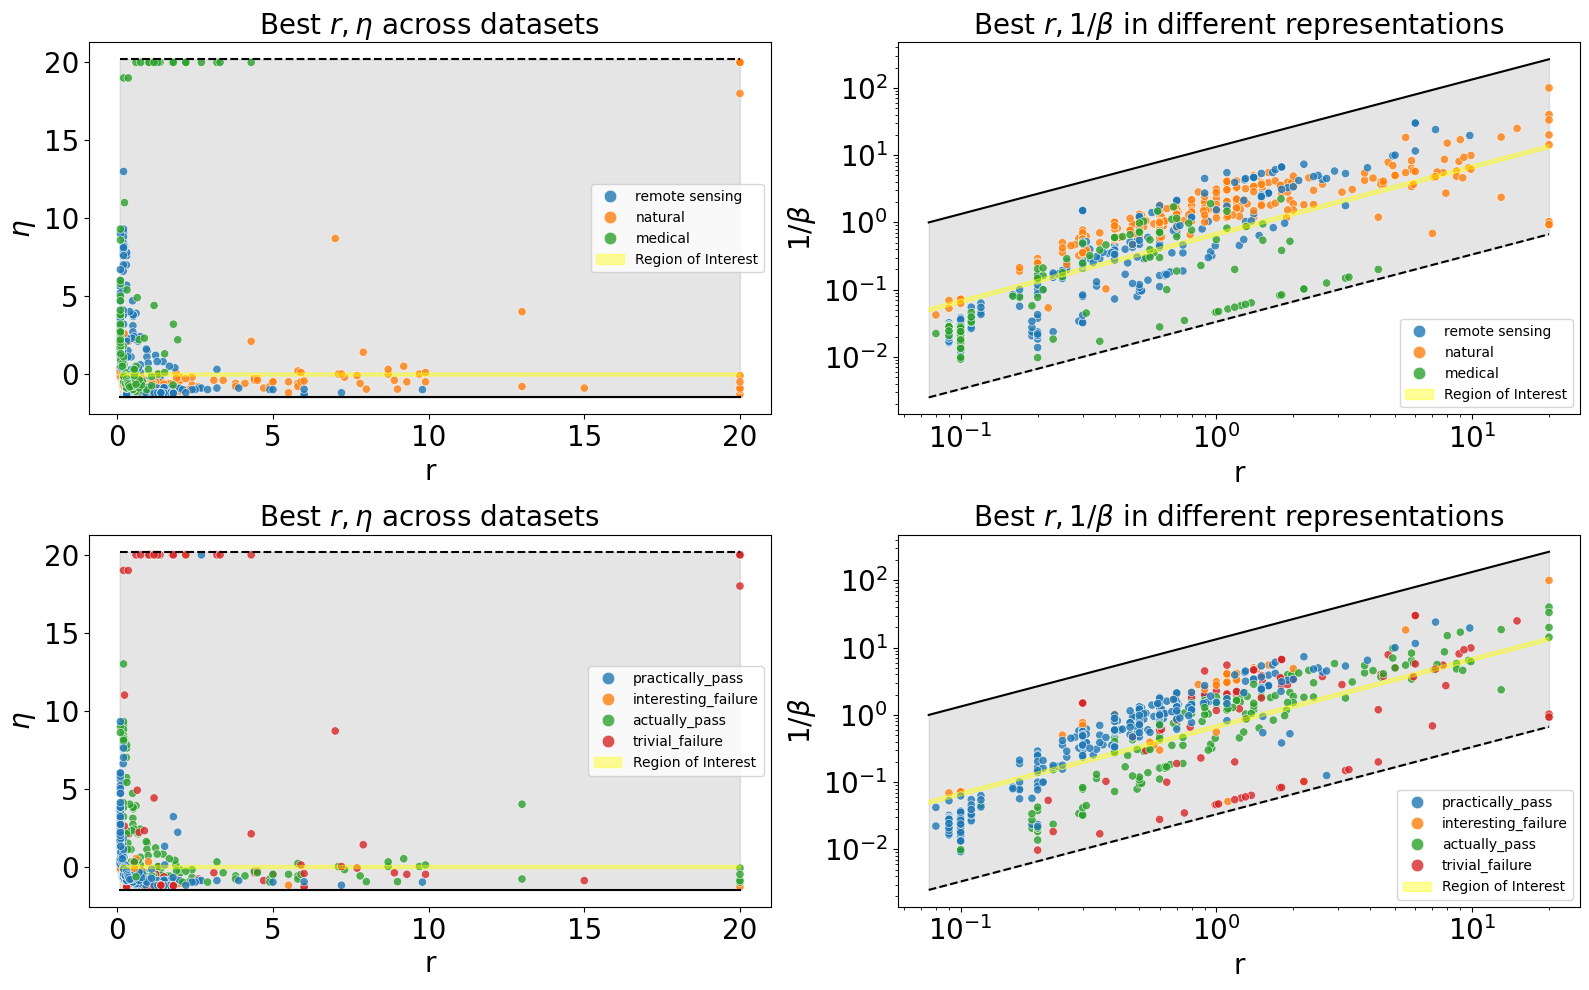

In [43]:
temp = main_df #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20.2)
r_roi = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = 1 / (3 / (2 * r_vals) / 20)
beta_vals_below = 1 / (3 / (2 * r_vals) * 20)

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
beta_vals_roi_above = 1 / (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = 1 / (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = 1 / beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# First plot (top left): r-eta space
axes[0, 0].fill_between(r_vals, y1=eta_valid[0], y2=eta_valid[1], color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset_type', ax=axes[0, 0], alpha=0.8)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0, 0], linestyle="--")
axes[0, 0].fill_between(r_vals_roi, eta_roi[0], eta_roi[1], color='yellow', alpha=0.4, label="Region of Interest")
axes[0, 0].set_title(r'Best $r, \eta$ across datasets', fontsize=20)
axes[0, 0].set_xlabel("r", fontsize=20)
axes[0, 0].set_ylabel(r'$\eta$', fontsize=20)
axes[0, 0].tick_params(axis='both', which='major', labelsize=20)
axes[0, 0].legend(markerscale=1.5, fontsize=10, loc='center right')

# Second plot (top right): r-(1/beta) space
axes[0, 1].fill_between(r_vals, beta_vals_above, beta_vals_below, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_1/beta', hue='dataset_type', ax=axes[0, 1], alpha=0.8)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[0, 1])
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[0, 1], linestyle="--")
axes[0, 1].fill(x_border_beta, y_border_beta, color='yellow', alpha=0.4, label="Region of Interest")
axes[0, 1].set_title(r'Best $r, 1/\beta$ in different representations', fontsize=20)
axes[0, 1].set_xlabel("r", fontsize=20)
axes[0, 1].set_ylabel(r'$1/\beta$', fontsize=20)
axes[0, 1].tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_yscale('log')
axes[0, 1].legend(markerscale=1.5, fontsize=10, loc='lower right')

# Third plot (bottom left): r-eta space with failure categories
axes[1, 0].fill_between(r_vals, y1=eta_valid[0], y2=eta_valid[1], color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='failure_category', ax=axes[1, 0], alpha=0.8)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[1, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[1, 0], linestyle="--")
axes[1, 0].fill(x_border, y_border, color='yellow', alpha=0.4, label="Region of Interest")
axes[1, 0].set_title(r'Best $r, \eta$ across datasets', fontsize=20)
axes[1, 0].set_xlabel("r", fontsize=20)
axes[1, 0].set_ylabel(r'$\eta$', fontsize=20)
axes[1, 0].tick_params(axis='both', which='major', labelsize=20)
axes[1, 0].legend(markerscale=1.5, fontsize=10, loc='center right')

# Fourth plot (bottom right): r-(1/beta) space with failure categories
axes[1, 1].fill_between(r_vals, beta_vals_below, beta_vals_above, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_1/beta', hue='failure_category', ax=axes[1, 1], alpha=0.8)
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1, 1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1, 1])
axes[1, 1].fill(x_border_beta, y_border_beta, color='yellow', alpha=0.4, label="Region of Interest")
axes[1, 1].set_title(r'Best $r, 1/\beta$ in different representations', fontsize=20)
axes[1, 1].set_xlabel("r", fontsize=20)
axes[1, 1].set_ylabel(r'$1/\beta$', fontsize=20)
axes[1, 1].tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
axes[1, 1].legend(markerscale=1.5, fontsize=10, loc='lower right')

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "type_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

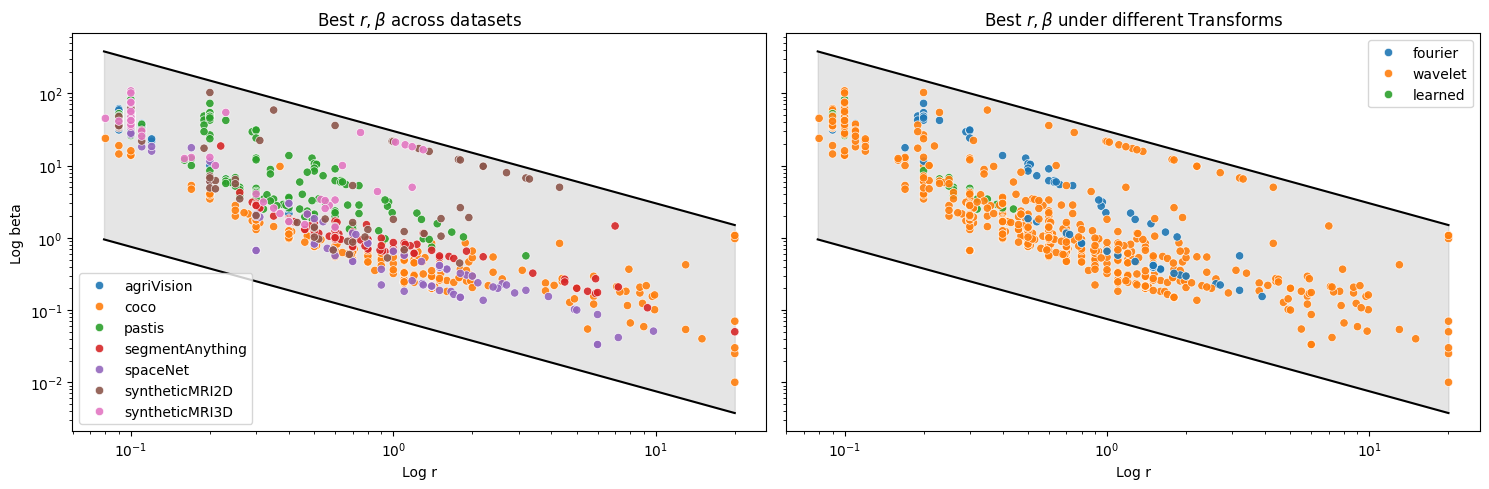

In [44]:
temp = main_df
log_scale = True
r_vals = np.linspace(temp['best_r'].min() - 0.001, temp['best_r'].max(), 1001)
beta_vals = 3 / (2 * r_vals) / 20

r_vals_2 = np.linspace(temp['best_r'].min() - 0.001,  temp['best_r'].max(), 1001)
beta_vals_2 = 3 / (2 * r_vals_2) * 20

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
ax1.fill_between(r_vals, beta_vals, beta_vals_2, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.9)
sns.lineplot(x=r_vals, y=beta_vals, color='black', ax=ax1)
sns.lineplot(x=r_vals_2, y=beta_vals_2, color='black', ax=ax1)
ax1.set_title(r'Best $r, \beta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
ax2.fill_between(r_vals, beta_vals, beta_vals_2, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='transform', ax=ax2, alpha=0.9)
sns.lineplot(x=r_vals, y=beta_vals, color='black', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, color='black', ax=ax2)
# Shade the region above the line

ax2.set_title(r'Best $r, \beta$ under different Transforms')
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


# KS Stats Across Priors

In [55]:
np.nan_to_num(stats.kstwo(n=main_df['total_samples']).isf(1e-119))

array([0.99997778, 0.99999145, 0.99999471, 0.99999798, 0.99999912,
       0.99999961, 0.99999983, 0.99999993, 0.99999997, 0.99999999,
       0.99999998, 0.99997778, 0.99999145, 0.99999471, 0.99999798,
       0.99999912, 0.99999961, 0.99999983, 0.99999993, 0.99999997,
       0.99999999, 0.99999998, 0.99997778, 0.99999145, 0.99999471,
       0.99999798, 0.99999912, 0.99999961, 0.99999983, 0.99999993,
       0.99999997, 0.99999999, 0.99999998, 0.99997778, 0.99999145,
       0.99999471, 0.99999798, 0.99999912, 0.99999961, 0.99999983,
       0.99999993, 0.99999997, 0.99999999, 0.99999998, 0.99977778,
       0.99994444, 0.99998611, 0.99999653, 0.99999913, 0.99999978,
       0.99999995, 0.99999999, 1.        , 0.99977778, 0.99994444,
       0.99998611, 0.99999653, 0.99999913, 0.99999978, 0.99999995,
       0.99999999, 1.        , 0.99977778, 0.99994444, 0.99998611,
       0.99999653, 0.99999913, 0.99999978, 0.99999995, 0.99999999,
       1.        , 0.99977778, 0.99994444, 0.99998611, 0.99999

In [89]:
statistical_cutoffs = -np.arange(1, 13, 2) # -np.hstack([np.arange(1, 13, 2), np.arange(14, 30, 2), np.arange(30, 100, 5)]) # -np.array([x**2 for x in range(1, 8)]) #np.arange(1, 40, 5)

for i in statistical_cutoffs:
    print(i)
    alpha = 10.0**i
    main_df[f'kstest_stat_cutoff_{i}'] = np.nan_to_num(stats.kstwo(n=main_df['total_samples']).isf(alpha))


alphas = np.linspace(0.1, 0.4, len(statistical_cutoffs))
alphas, [10.0**i for i in list(statistical_cutoffs)]

-1


c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


-3
-5
-7
-9
-11


(array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ]),
 [0.1, 0.001, 1e-05, 1e-07, 1e-09, 1e-11])

## Remote Sensing

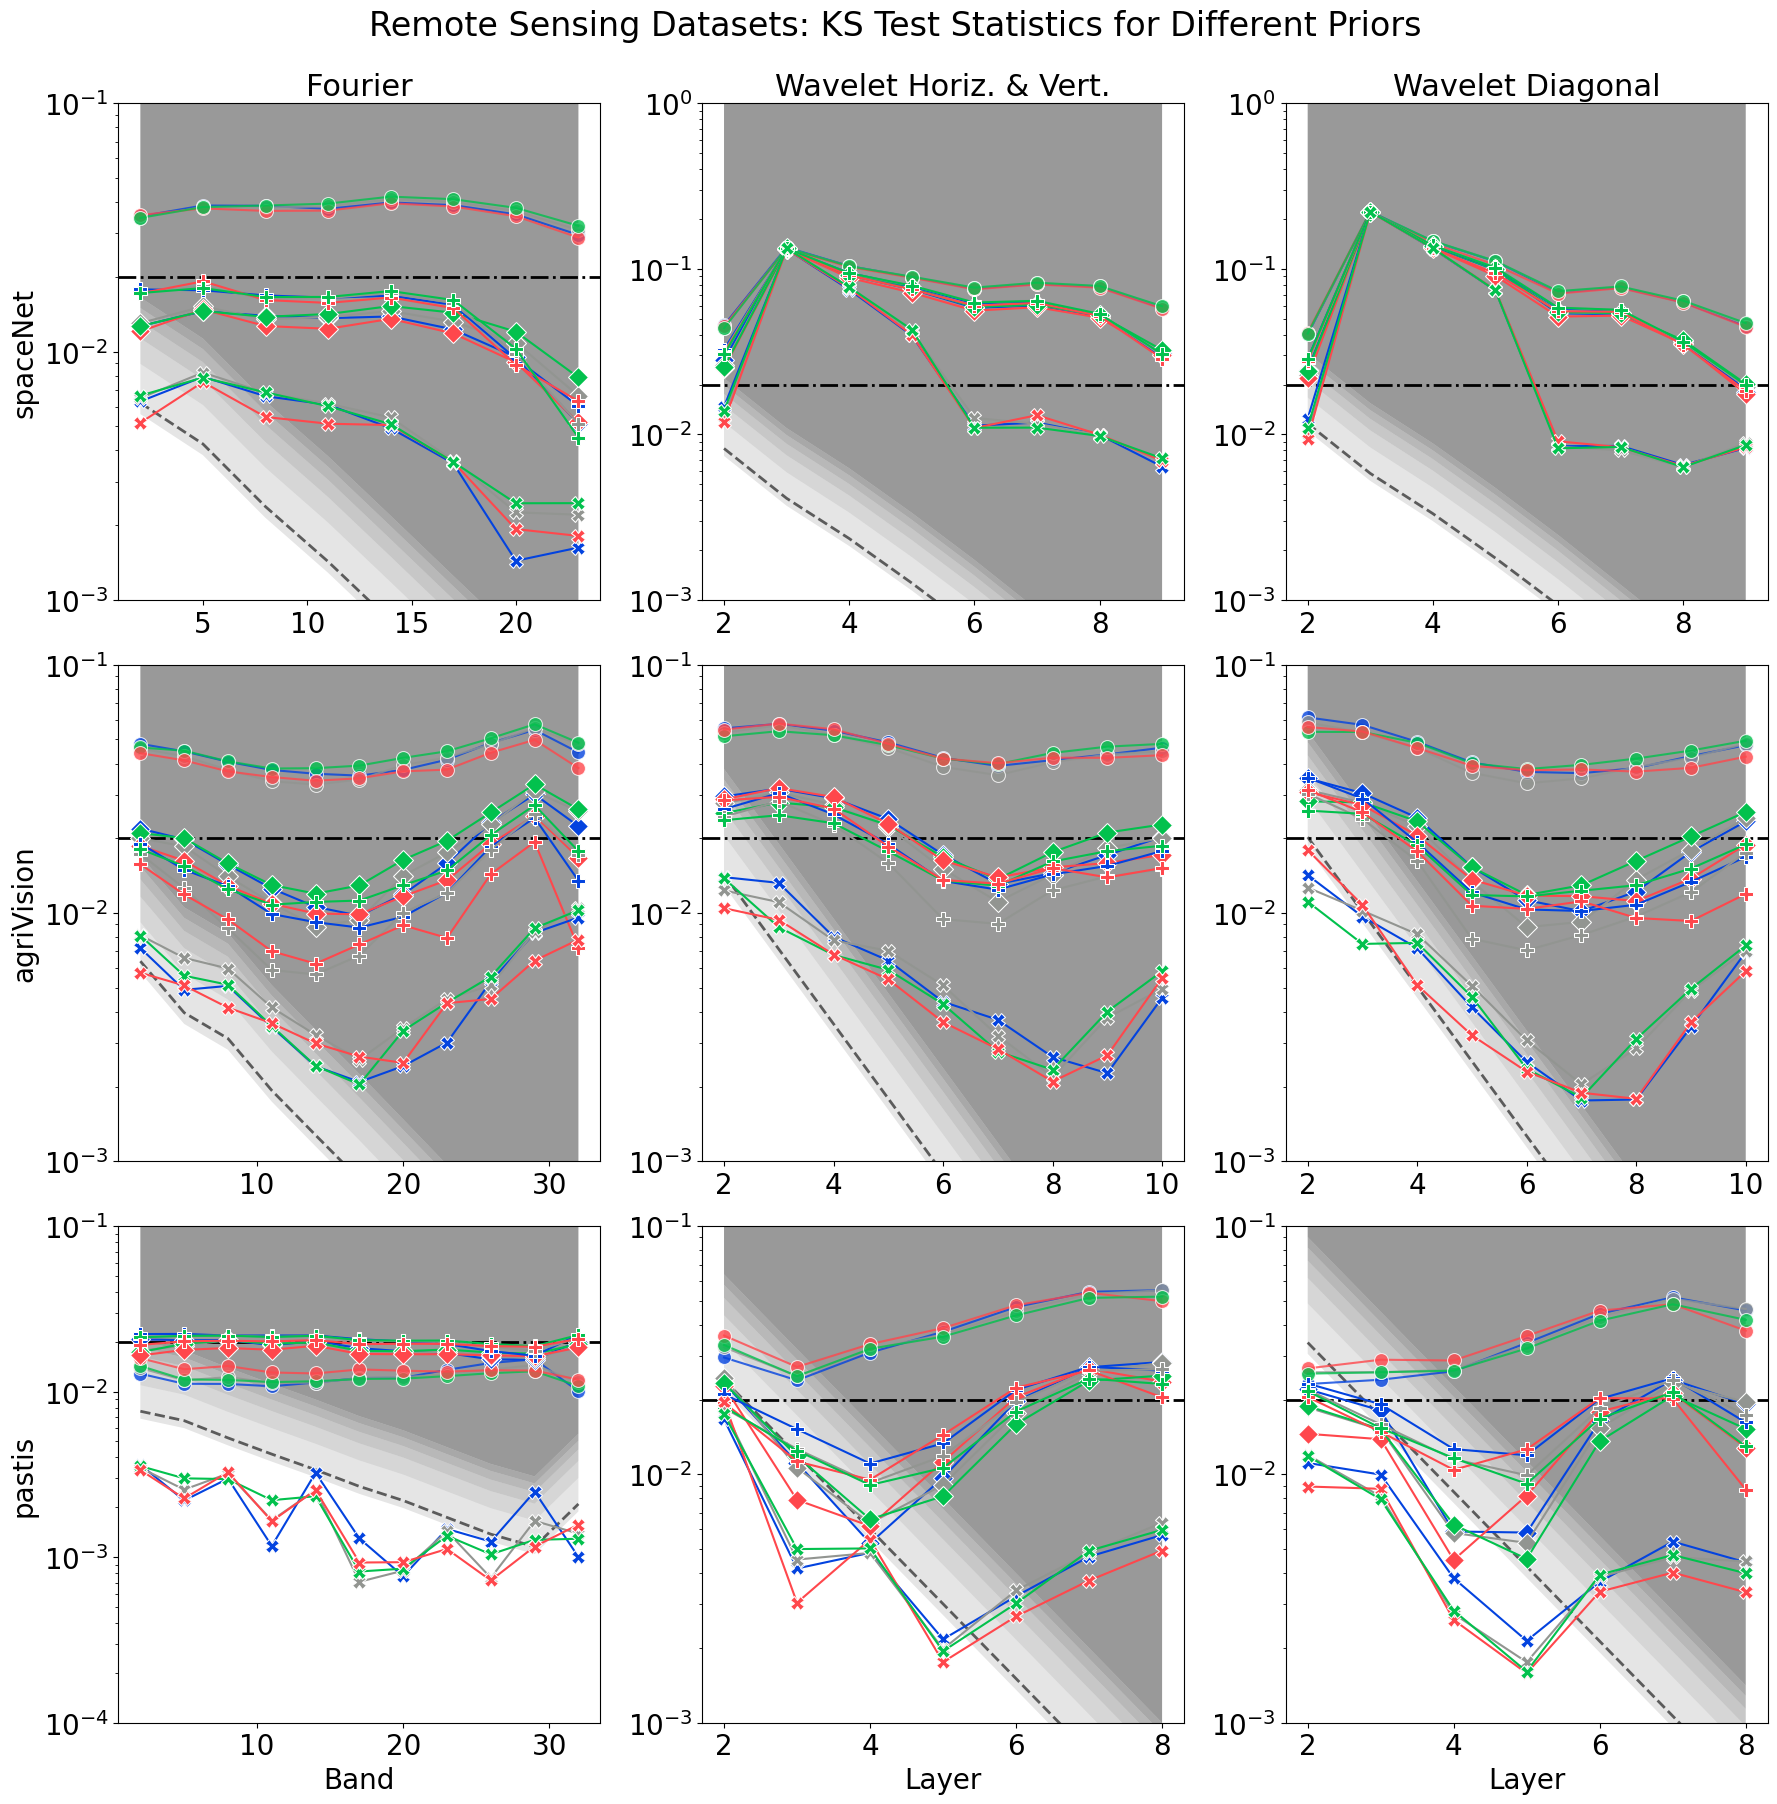

In [90]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable
log_scale = not False
datasets_to_include = ['spaceNet', 'agriVision', 'pastis']  # List of datasets to include
num_datasets = len(datasets_to_include)
fontsize = 20
practical_pass = 0.02

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets), sharey=False)


fig.suptitle("Remote Sensing Datasets: KS Test Statistics for Different Priors", y=1, fontsize=fontsize+4)

for i, dataset_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    if log_scale:
        axes[i, 0].set_yscale('log')
        axes[i, 1].set_yscale('log')
        axes[i, 2].set_yscale('log')

    # LEFT PLOT
    transform = 'fourier'
    GROUP_NAME = 'Band'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    
    # Region
    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 0].set_ylim(y_limits) 

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)
    
    # alpha=0.05
    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 0])
    
    # ks = 0.02
    axes[i, 0].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # results
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 0].set_xlabel("", fontsize=fontsize)
    axes[i, 0].set_ylabel(f"{dataset_name}", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)
    
    # MIDDLE PLOT
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizVert')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 1].set_ylim(y_limits)  

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 1])

    axes[i, 1].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)
    
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 1].set_xlabel("", fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)
   
    # RIGHT PLOT
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 2].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)


    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 2])

    axes[i, 2].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 2].set_xlabel("", fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

axes[0, 0].set_title(f"Fourier", fontsize=fontsize+2)
axes[0, 1].set_title(f"Wavelet Horiz. & Vert.", fontsize=fontsize+2)
axes[0, 2].set_title(f"Wavelet Diagonal", fontsize=fontsize+2)

axes[2, 0].set_xlabel("Band", fontsize=fontsize)
axes[2, 1].set_xlabel("Layer", fontsize=fontsize)
axes[2, 2].set_xlabel("Layer", fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "remote_sensing_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


# Natural Images

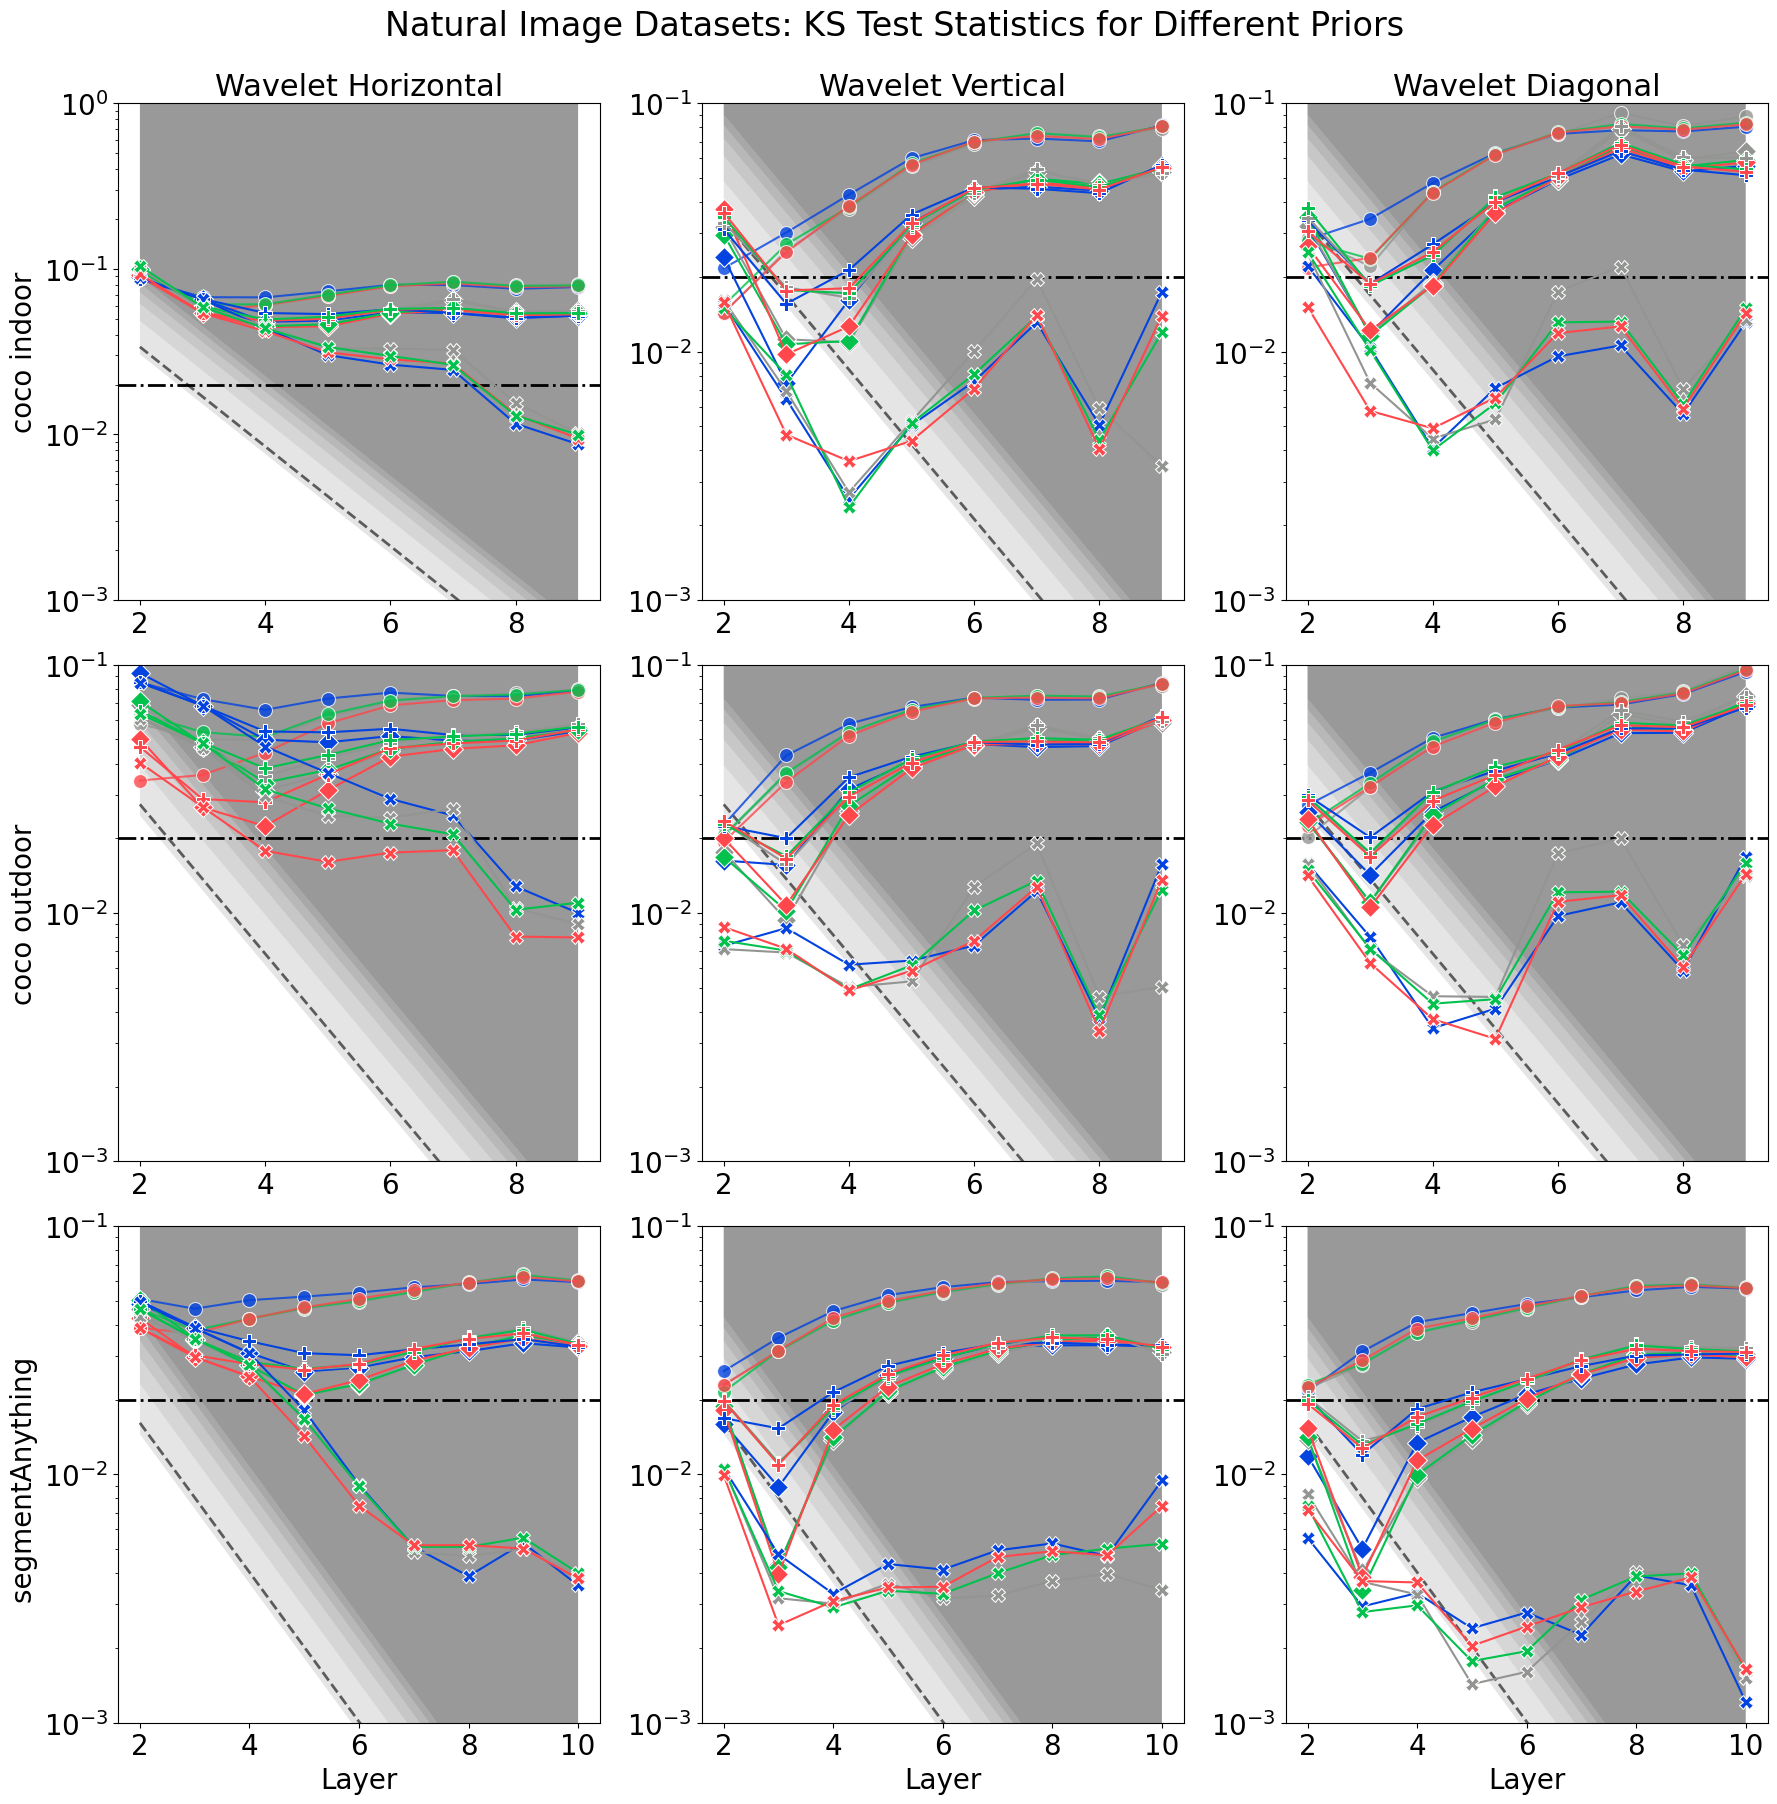

In [ ]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable
log_scale = not False
datasets_to_include = ['coco-indoor', 'coco-outdoor', 'segmentAnything-full']  # List of datasets to include
num_datasets = len(datasets_to_include)

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

fig.suptitle("Natural Image Datasets: KS Test Statistics for Different Priors", y=1, fontsize=fontsize + 4)

for i, data_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_name, subset_name = data_name.split("-")
    dataset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizontal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    if log_scale:
        axes[i, 0].set_yscale('log')
        axes[i, 1].set_yscale('log')
        axes[i, 2].set_yscale('log')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 0].set_ylim(y_limits) 

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)
    
    # alpha=0.05
    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 0])
    
    # ks = 0.02
    axes[i, 0].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # results
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 0].set_xlabel("", fontsize=fontsize)
    axes[i, 0].set_ylabel(f"{dataset_name} {f'{(subset_name)}' if dataset_name == 'coco' else ''}", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False) 
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)

    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'vertical')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 1].set_ylim(y_limits)  

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 1])

    axes[i, 1].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)
    
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 1].set_xlabel("", fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)

    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 2].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 2])

    axes[i, 2].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 2].set_xlabel("", fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

axes[0, 0].set_title(f"Wavelet Horizontal", fontsize=fontsize + 2)
axes[0, 1].set_title(f"Wavelet Vertical", fontsize=fontsize + 2)
axes[0, 2].set_title(f"Wavelet Diagonal", fontsize=fontsize + 2)

axes[2, 0].set_xlabel("Layer", fontsize=fontsize)
axes[2, 1].set_xlabel("Layer", fontsize=fontsize)
axes[2, 2].set_xlabel("Layer", fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "natural_images_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


# Medical Images

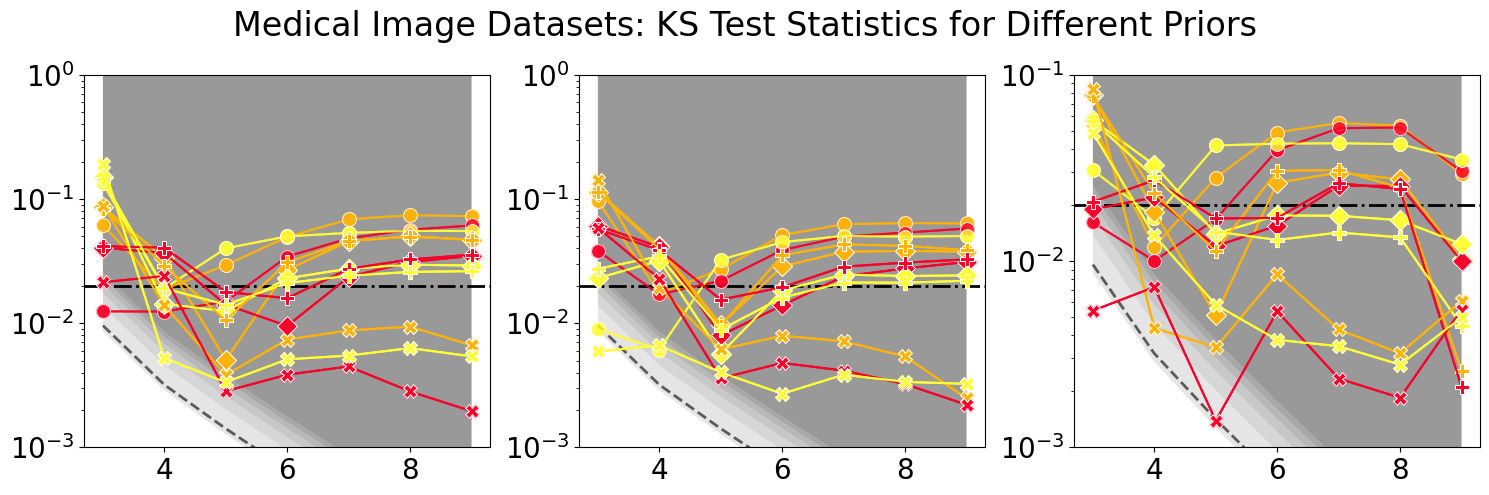

In [101]:
hue = 'subset'
fixed_palette = {'axial': 'xkcd:amber', 'coronal': 'xkcd:cherry red', 'sagittal': 'xkcd:sunshine yellow'}
marker_size = 10  # Define marker size
log_scale = True
dataset_name = 'syntheticMRI2D'
orientations = ['horizontal', 'vertical', 'diagonal']  # List of subsets to include
num_subsets = len(orientations)
fig, axes = plt.subplots(1, num_subsets, figsize=(5 * num_subsets, 5))

fig.suptitle("Medical Image Datasets: KS Test Statistics for Different Priors", fontsize=fontsize+4)

if num_subsets == 1:
    axes = [axes]

for j, orientation in enumerate(orientations):

    if log_scale:
        axes[j].set_yscale('log')

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['group'] > 2) & (main_df['orientation'] == orientation)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
                10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
    axes[j].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[j].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[j].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)


    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size, markeredgecolor=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[j])

    axes[j].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[j].set_xlabel("", fontsize=fontsize)
    axes[j].set_ylabel("", fontsize=fontsize)
    axes[j].legend(points, labels, fontsize=12).set_visible(False)
    axes[j].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"{dataset_name}_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


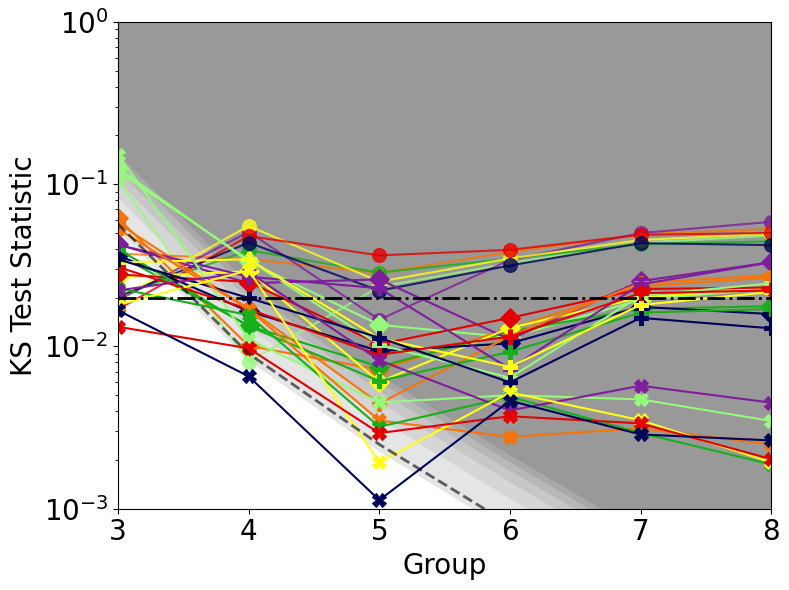

In [106]:
# Define a custom palette for orientations
orientation_palette = {
    'aad': 'xkcd:light green',
    'ada': 'xkcd:orange',
    'add': 'xkcd:green',
    'daa': 'xkcd:purple',
    'dad': 'xkcd:yellow',
    'dda': 'xkcd:red',
    'ddd': 'xkcd:dark blue'
}

# Filter data for the dataset and subset
data_name = 'syntheticMRI3D'
dataset_filter = (main_df['dataset'] == data_name) & (main_df['subset'] == 'full')
transform_filter = (main_df['transform'] == 'wavelet')
temp = main_df[dataset_filter & transform_filter]
log_scale = True
hue = 'orientation'

fig, ax = plt.subplots(figsize=(8, 6))

if log_scale:
    ax.set_yscale('log')

y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
            10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
ax.set_ylim(y_limits)
ax.set_xlim((3, 8))

cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
for k, alpha in enumerate(statistical_cutoffs[:-1]):
    ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=orientation_palette, marker='o', alpha=0.8, ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=orientation_palette, marker='D', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=orientation_palette, marker='P', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=orientation_palette, marker='X', ax=ax, markersize=marker_size, markeredgecolor=None)

cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax)

ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

ax.set_xlabel("Group", fontsize=fontsize)
ax.set_ylabel("KS Test Statistic", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=12).set_visible(False)

plt.tight_layout()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "syntheticMRI3D_ksstats.jpg")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()


C:\Users\yashd\AppData\Local\Temp\ipykernel_42616\3417614616.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian',palette=orientation_palette, marker='o', alpha=0.8, ax=ax, markersize=marker_size, markeredgecolor=None)
C:\Users\yashd\AppData\Local\Temp\ipykernel_42616\3417614616.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_laplace',  palette=orientation_palette, marker='D', ax=ax, markersize=marker_size, markeredgecolor=None)
C:\Users\yashd\AppData\Local\Temp\ipykernel_42616\3417614616.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_t',  palette=orientation_palette, marker='P', ax=ax, markersize=marker_size, markeredgecolor=None)
C:\Users\yashd\AppData\Local\Temp\ipykernel_42616\3417614616.py:38: UserWarning: Ignoring 

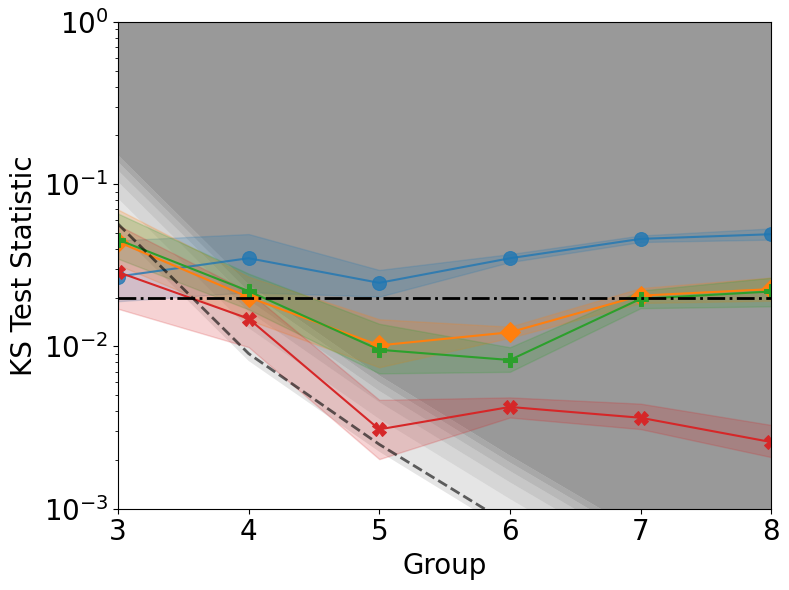

In [ ]:
# Define a custom palette for orientations
orientation_palette = {
    'aad': 'xkcd:light green',
    'ada': 'xkcd:orange',
    'add': 'xkcd:green',
    'daa': 'xkcd:purple',
    'dad': 'xkcd:yellow',
    'dda': 'xkcd:red',
    'ddd': 'xkcd:dark blue'
}

# Filter data for the dataset and subset
data_name = 'syntheticMRI3D'
dataset_filter = (main_df['dataset'] == data_name) & (main_df['subset'] == 'full')
transform_filter = (main_df['transform'] == 'wavelet')
temp = main_df[dataset_filter & transform_filter]
log_scale = True
# hue = 'orientation'

fig, ax = plt.subplots(figsize=(8, 6))

if log_scale:
    ax.set_yscale('log')

y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
            10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
ax.set_ylim(y_limits)
ax.set_xlim((3, 8))

cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
for k, alpha in enumerate(statistical_cutoffs[:-1]):
    ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian',palette=orientation_palette, marker='o', alpha=0.8, ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace',  palette=orientation_palette, marker='D', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', palette=orientation_palette, marker='P', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', palette=orientation_palette, marker='X', ax=ax, markersize=marker_size, markeredgecolor=None)

cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax)

ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

ax.set_xlabel("Group", fontsize=fontsize)
ax.set_ylabel("KS Test Statistic", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=12).set_visible(False)

plt.tight_layout()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "syntheticMRI3D_ksstats.jpg")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()


# Learned Filters

In [110]:
nonskewed_df = pd.read_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv')).set_index(['dataset', 'num_images', 'num_bootstrap'])
nonskewed_df

nonskewed_filter_idxs
dataset              num_images num_bootstrap                                                   
coco-indoor          100        1000           [ 0,  4,  5,  6,  8,  9, 11, 12, 16, 18, 22, 2...
pastis-full          10         10             [2, 3, 4, 9, 10, 11, 12, 14, 16, 18, 20, 22, 2...
                     1590       1000           [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18,...
coco-indoor          100        100            [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
coco-outdoor         100        100            [0, 2, 3, 4, 5, 7, 8, 9, 12, 13, 15, 16, 17, 1...
                     1000       1000           [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 1...
coco-indoor          1000       1000           [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 1...
spaceNet-full        1000       1000           [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
segmentAnything-full 1000       1000           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...

In [ ]:
intersection = set.intersection(*[set(eval(i)) for i in nonskewed_df['nonskewed_filter_idxs']])
intersection

{4, 9, 12, 16, 18, 22, 25, 27, 33, 38, 41, 47, 48, 49, 55, 57, 63}

In [ ]:
filters = pd.read_pickle(os.path.join(ROOT_DIR, 'learned-filters', 'filters.pickle'))

In [ ]:
fixed_palette = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'yellow',
                'dual_color': 'lightgreen',
                'inside_out': 'purple',
                'misc': 'orange'}

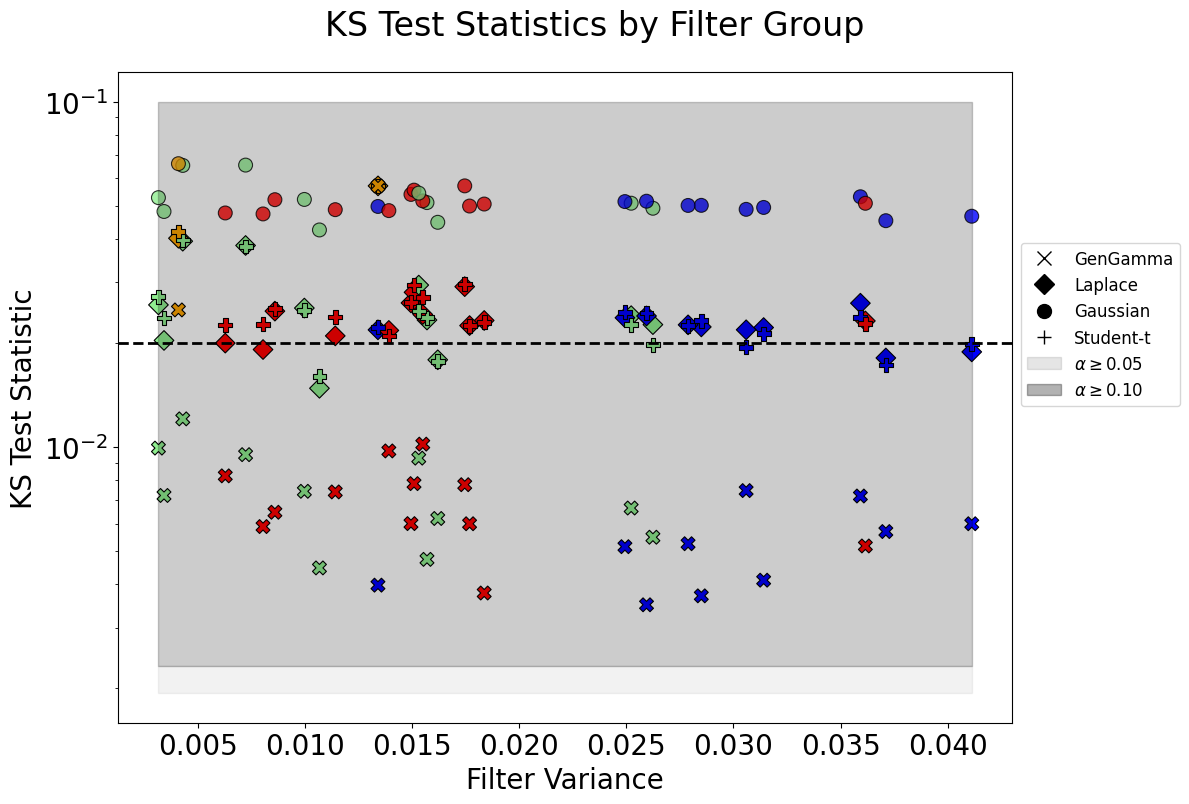

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("KS Test Statistics by Filter Group", y=1, fontsize=fontsize + 4)
transform = 'learned'
temp = main_df[main_df['transform'] == transform].copy()
temp['filter_var'] = [np.var(filters[i]) for i in temp['group']]

sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', hue='channel', palette=fixed_palette, marker='o', alpha=0.8, ax=ax, s=100, edgecolor='black')
sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', hue='channel', palette=fixed_palette, marker='D', ax=ax, s=100, edgecolor='black')
sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', hue='channel', palette=fixed_palette, marker='P', ax=ax, s=100, edgecolor='black')
sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_best', hue='channel', palette=fixed_palette, marker='X', ax=ax, s=100, edgecolor='black')

cutoff = temp.groupby('filter_var').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
ax.fill_between(cutoff['filter_var'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.05)
ax.fill_between(cutoff['filter_var'], cutoff['kstest_stat_cutoff_0.10'], 0.1, color='black', alpha=0.2)
ax.legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))#.set_visible(False)
ax.set_xlabel("Filter Variance", fontsize=fontsize)
ax.set_ylabel("KS Test Statistic", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

if log_scale:
    ax.set_yscale('log')

practical_pass = 0.02
ax.axhline(y=practical_pass, linestyle="--", color='black', linewidth=2)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ks_stats_by_filter_group_combined.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


C:\Users\yashd\AppData\Local\Temp\ipykernel_27372\1216268384.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i // 3, i % 3])
C:\Users\yashd\AppData\Local\Temp\ipykernel_27372\1216268384.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', palette=fixed_palette, marker='D', ax=axes[i // 3, i % 3])
C:\Users\yashd\AppData\Local\Temp\ipykernel_27372\1216268384.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', palette=fixed_palette, marker='P', ax=axes[i // 3, i % 3])
C:\Users\yashd\AppData\Local\Temp\ipykernel_27372\1216268384.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp,

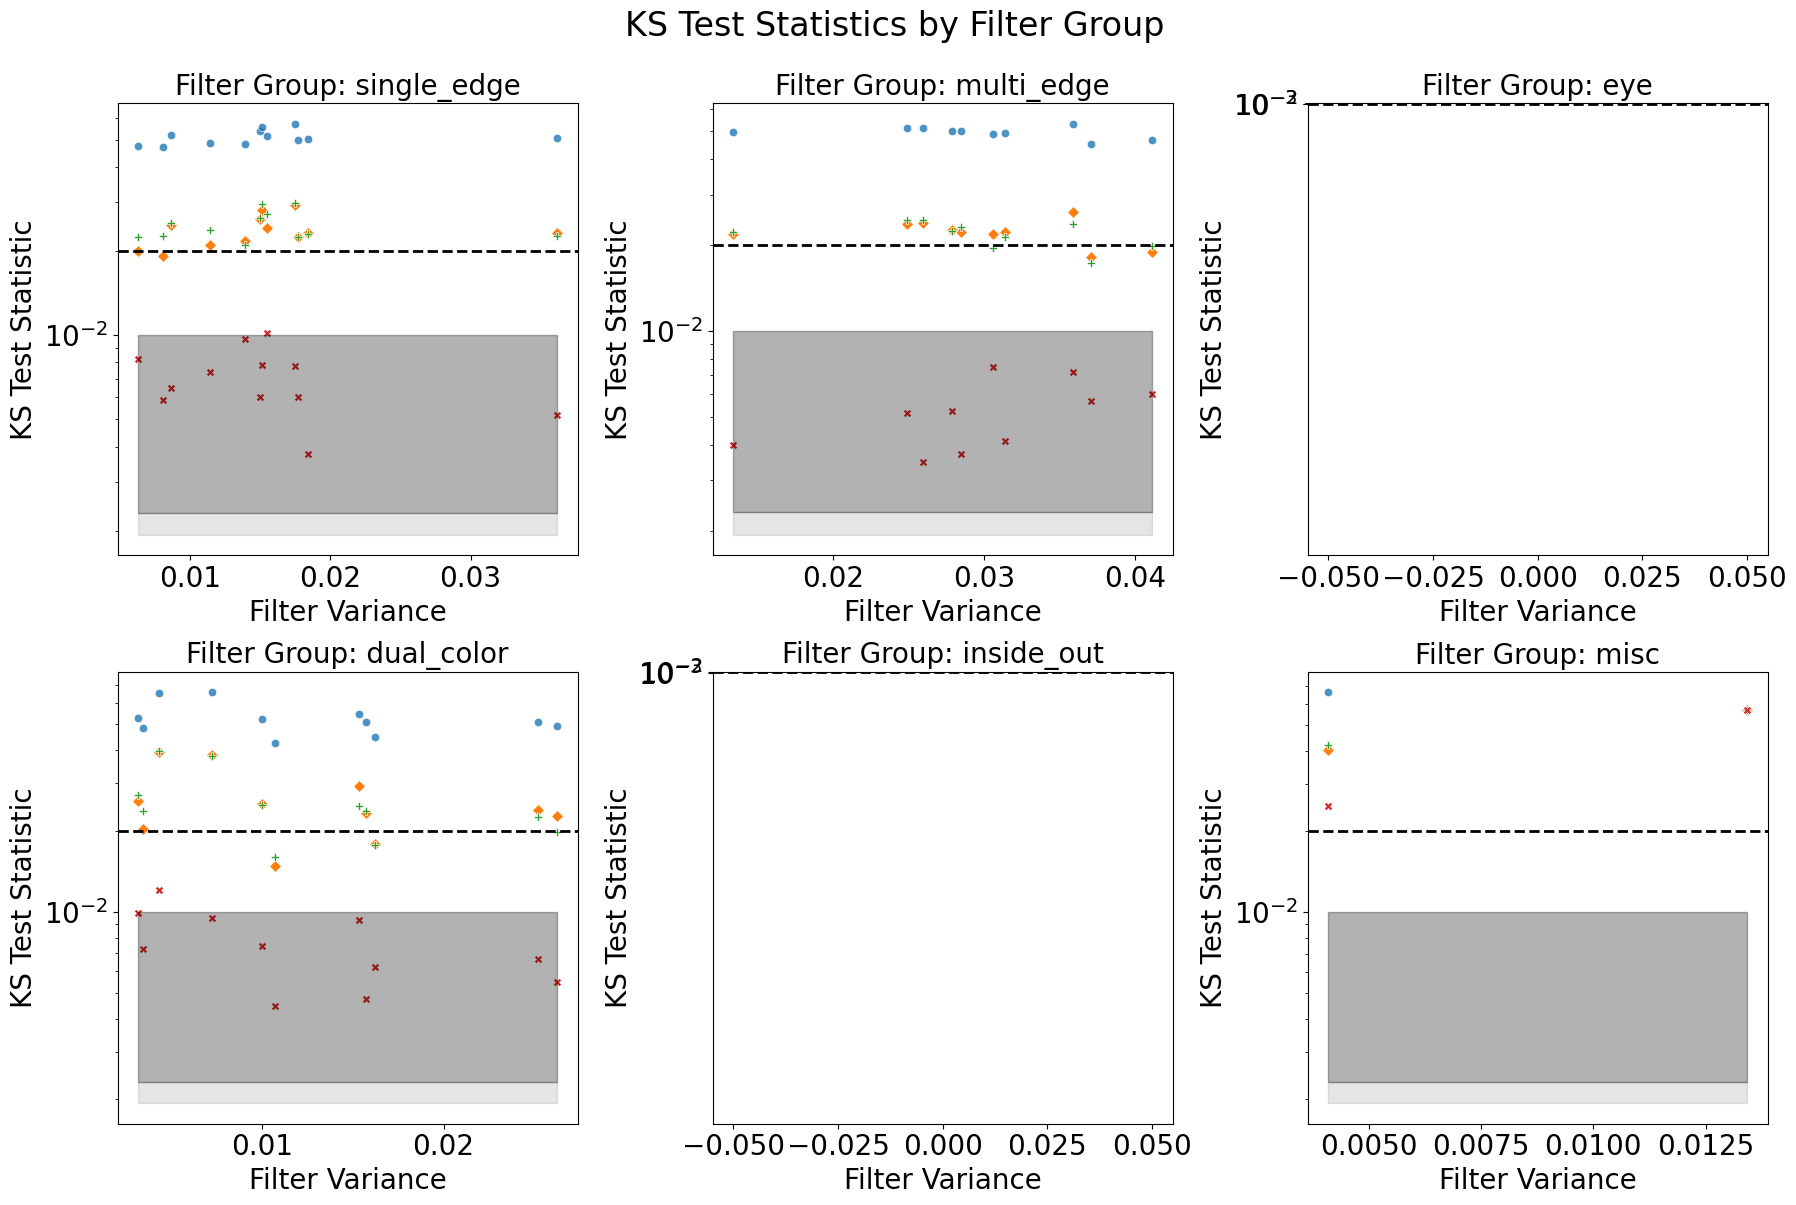

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust layout for 2 rows and 3 columns
fig.suptitle("KS Test Statistics by Filter Group", y=1, fontsize=fontsize + 4)

for i, filter_group in enumerate(fixed_palette.keys()):  # Iterate over 6 filter groups
    temp = main_df[(main_df['channel'] == filter_group) & (main_df['transform'] == transform)].copy()
    temp['filter_var'] = [np.var(filters[i]) for i in temp['group']]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i // 3, i % 3])
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', palette=fixed_palette, marker='D', ax=axes[i // 3, i % 3])
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', palette=fixed_palette, marker='P', ax=axes[i // 3, i % 3])
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_best', palette=fixed_palette, marker='X', ax=axes[i // 3, i % 3])

    # y_limits = (0, 0.1)
    # axes[i // 3, i % 3].set_ylim(y_limits)

    cutoff = temp.groupby('filter_var').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i // 3, i % 3].fill_between(cutoff['filter_var'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i // 3, i % 3].fill_between(cutoff['filter_var'], cutoff['kstest_stat_cutoff_0.10'], 0.01, color='black', alpha=0.3)
    axes[i // 3, i % 3].set_xlabel("Filter Variance", fontsize=fontsize)
    axes[i // 3, i % 3].set_ylabel("KS Test Statistic", fontsize=fontsize)
    axes[i // 3, i % 3].set_title(f"Filter Group: {filter_group}", fontsize=fontsize)
    axes[i // 3, i % 3].tick_params(axis='both', which='major', labelsize=fontsize)

    if log_scale:
        axes[i // 3, i % 3].set_yscale('log')

    practical_pass = 0.02
    axes[i // 3, i % 3].axhline(y=practical_pass, linestyle="--", color='black', linewidth=2)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ks_stats_by_filter_group.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')
